In [1]:
import pandas as pd

# Load dataset from the specified path
file_path = r"C:\Users\P.Carbon\Downloads\Project-Budget\Data3.csv"
df = pd.read_csv(file_path)
print(df.head(2))
print(df.tail(2))

   Year  Budget   GDP
0  1972     786  4717
1  1973     995  6066
    Year  Budget      GDP
52  2024  797000  5597414
53  2025  790000  6244578


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Load dataset
file_path = r"C:\Users\P.Carbon\Downloads\Project-Budget\Data3.csv"
df = pd.read_csv(file_path)

budget = df['Budget'].values.astype(float)
years = df['Year'].values

# Log transformation
log_budget = np.log(budget)

# Search ranges
p_range = range(0, 4)
d_range = range(0, 3)
q_range = range(0, 4)

results_list = []

# Loop through combinations
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = ARIMA(log_budget, order=(p, d, q))
                fitted = model.fit()
                
                # Calculate RMSE on in-sample fit
                rmse = np.sqrt(mean_squared_error(log_budget, fitted.fittedvalues))
                
                results_list.append({
                    "order": (p, d, q),
                    "AIC": fitted.aic,
                    "BIC": fitted.bic,
                    "RMSE": rmse
                })
            except:
                continue

# Convert to DataFrame and sort
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by="AIC").reset_index(drop=True)

# Top 5 models
top_5 = results_df.head(5)
print("\nTop 5 ARIMA models:")
print(top_5)


In [12]:
import pandas as pd
import numpy as np
import random
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

# Load data

budget = df['Budget'].values.astype(float)
years = df['Year'].values

# Train/test split
train_size = int(len(budget) * 0.80)
budget_train = budget[:train_size]
budget_test = budget[train_size:]

# Define MAPE and Accuracy
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define ARIMA orders grid
arima_orders = [(p, d, q) for p in range(1, 4) for d in range(1, 3) for q in range(1, 4)]

# Store results
results = []

# Loop through each ARIMA(p,d,q)
for order in arima_orders:
    try:
        model = ARIMA(budget_train, order=order).fit()
        pred = model.predict(start=train_size, end=len(budget)-1)

        # Evaluation metrics
        rmse = np.sqrt(mean_squared_error(budget_test, pred))
        mae = mean_absolute_error(budget_test, pred)
        mape_val = mape(budget_test, pred)
        accuracy = 100 - mape_val  # approximate accuracy
        r2 = r2_score(budget_test, pred)

        results.append({
            'ARIMA_Order': order,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape_val,
            'Accuracy (%)': accuracy,
            'R2': r2
        })

    except Exception as e:
        continue  # skip models that fail to fit

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Find best model by RMSE
best_arima = results_df.sort_values('RMSE').head(1)

# Print the best model
print("\n✅ Best ARIMA Model Based on Test RMSE:")
print(best_arima.round(4))



✅ Best ARIMA Model Based on Test RMSE:
   ARIMA_Order        RMSE         MAE    MAPE  Accuracy (%)      R2
11   (2, 2, 3)  78955.7682  69954.2424  11.575        88.425  0.7855


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step

📊 Final Evaluation: Hybrid ARIMA(2,2,3) + LSTM
✅ RMSE         : 90592.8965
✅ MAE          : 87152.4866
✅ MAPE (%)     : 13.53
✅ Accuracy (%) : 86.47
✅ R² Score     : 0.4231


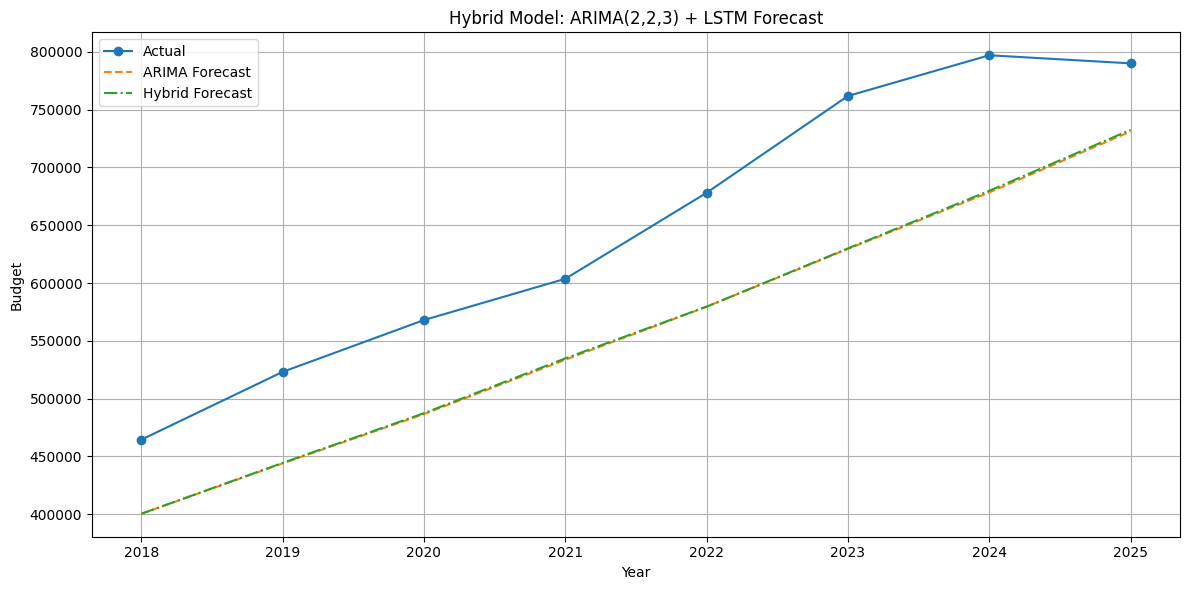

In [ ]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Setup
warnings.filterwarnings("ignore")
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load data

budget = df['Budget'].values.astype(float)
years = df['Year'].values

# Split
total_size = len(budget)
train_size = int(total_size * 0.8)
budget_train, budget_test = budget[:train_size], budget[train_size:]
years_test = years[train_size:]

# Metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy_from_mape(mape_val):
    return 100 - mape_val

# Best ARIMA(2,2,3)
order = (2, 2, 3)
best_arima_model = ARIMA(budget_train, order=order).fit()
arima_pred_test = best_arima_model.predict(start=train_size, end=total_size-1)
arima_resid_train = best_arima_model.resid

# LSTM config: time_steps=3, units=8, dropout=0.2, batch_size=8
scaler = MinMaxScaler()
budget_scaled = scaler.fit_transform(budget.reshape(-1, 1))

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Hybrid ARIMA + LSTM on residuals
scaler_resid = MinMaxScaler()
resid_scaled = scaler_resid.fit_transform(arima_resid_train.reshape(-1, 1))
time_steps = 3
Xr, yr = create_sequences(resid_scaled, time_steps)
Xr_train = Xr[:int(len(Xr)*0.8)]
Xr_test = Xr[int(len(Xr)*0.8):]
yr_train = yr[:int(len(yr)*0.8)]
yr_test = yr[int(len(yr)*0.8):]

model_hybrid = Sequential([
    LSTM(8, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(8),
    Dropout(0.2),
    Dense(1)
])
model_hybrid.compile(optimizer='adam', loss='mse')
model_hybrid.fit(Xr_train, yr_train, epochs=100, batch_size=8,
                 validation_split=0.1, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)

yr_pred_scaled = model_hybrid.predict(Xr_test)
yr_pred = scaler_resid.inverse_transform(yr_pred_scaled).flatten()
arima_last = best_arima_model.predict(start=train_size, end=total_size-1)
arima_part = arima_last[-len(yr_pred):]
hybrid_pred = arima_part + yr_pred
hybrid_true = budget[-len(hybrid_pred):]

# Hybrid Metrics
hybrid_rmse = np.sqrt(mean_squared_error(hybrid_true, hybrid_pred))
hybrid_mae = mean_absolute_error(hybrid_true, hybrid_pred)
hybrid_mape_val = mape(hybrid_true, hybrid_pred)
hybrid_r2 = r2_score(hybrid_true, hybrid_pred)
hybrid_acc = accuracy_from_mape(hybrid_mape_val)

# Print Results
print("\n\U0001F4CA Final Evaluation: Hybrid ARIMA(2,2,3) + LSTM")
print(f"\u2705 RMSE         : {hybrid_rmse:.4f}")
print(f"\u2705 MAE          : {hybrid_mae:.4f}")
print(f"\u2705 MAPE (%)     : {hybrid_mape_val:.2f}")
print(f"\u2705 Accuracy (%) : {hybrid_acc:.2f}")
print(f"\u2705 R² Score     : {hybrid_r2:.4f}")

# Optional Plot
plt.figure(figsize=(12, 6))
plt.plot(years_test[-len(hybrid_pred):], hybrid_true, label='Actual', marker='o')
plt.plot(years_test[-len(hybrid_pred):], arima_part, label='ARIMA Forecast', linestyle='--')
plt.plot(years_test[-len(hybrid_pred):], hybrid_pred, label='Hybrid Forecast', linestyle='-.')
plt.xlabel("Year")
plt.ylabel("Budget")
plt.title("Hybrid Model: ARIMA(2,2,3) + LSTM Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 346ms/step
✅ Best ANN Model:
Units: 64, Dropout: 0.1, Batch size: 8
RMSE: 34533.5203, MAE: 29742.8097
MAPE (%): 5.51, Accuracy (%): 94.49
R2 Score: 0.9590
1/1 [==============================] - 0s 104ms/step
Forecast for next 5 years:
Year 2026: 966101.00
Year 2027: 1067837.25
Year 2028: 1193452.75
Year 2029: 1347719.25
Year 2030: 1508099.25


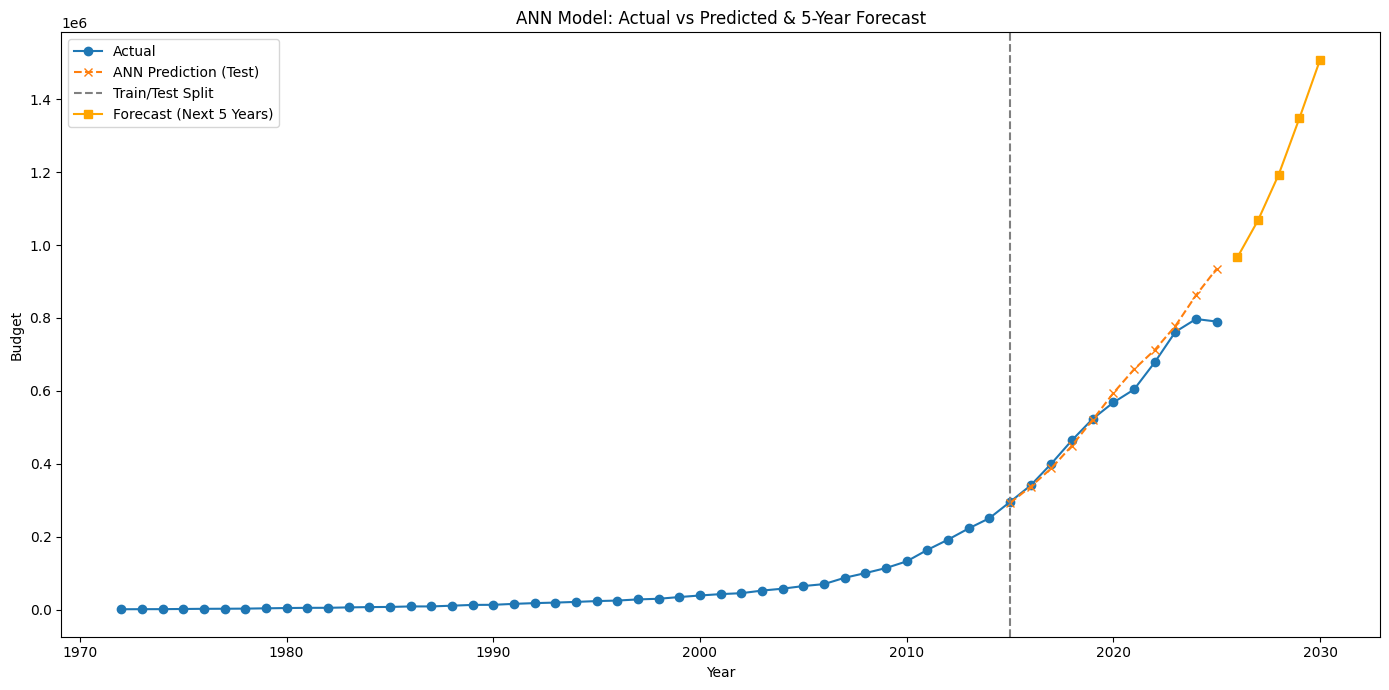

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Setup seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load data
file_path = r"C:\\Users\\P.Carbon\\Downloads\\Project-Budget\\Data3.csv"
df = pd.read_csv(file_path)
budget = df['Budget'].values.astype(float)
years = df['Year'].values

# Train/test split
train_size = int(len(budget) * 0.80)
budget_train, budget_test = budget[:train_size], budget[train_size:]

# Scale data
scaler = MinMaxScaler()
budget_scaled = scaler.fit_transform(budget.reshape(-1, 1))
train_scaled = budget_scaled[:train_size]
test_scaled = budget_scaled[train_size:]

# Prepare sequences for ANN (using previous 3 values to predict next)
def create_seq_ann(data, time_steps=3):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i].flatten())
        y.append(data[i])
    return np.array(X), np.array(y)

time_steps = 3
X, y = create_seq_ann(budget_scaled, time_steps)
X_train, X_test = X[:train_size-time_steps], X[train_size-time_steps:]
y_train, y_test = y[:train_size-time_steps], y[train_size-time_steps:]

# Hyperparameters grid
units_list = [8, 16, 32, 64]
dropout_rates = [0.0, 0.1, 0.2]
batch_sizes = [8, 16]

results = []

for units in units_list:
    for dropout_rate in dropout_rates:
        for batch_size in batch_sizes:
            # Build model
            model = Sequential([
                Dense(units, activation='relu', input_shape=(time_steps,)),
                Dropout(dropout_rate),
                Dense(units, activation='relu'),
                Dropout(dropout_rate),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')

            # Train
            early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                      validation_split=0.1, callbacks=[early_stop], verbose=0)

            # Predict and inverse scale
            y_pred_scaled = model.predict(X_test)
            y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
            y_true = scaler.inverse_transform(y_test).flatten()

            # Metrics
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            accuracy = 100 - mape

            results.append({
                'units': units,
                'dropout': dropout_rate,
                'batch_size': batch_size,
                'RMSE': rmse,
                'MAE': mae,
                'MAPE': mape,
                'Accuracy (%)': accuracy,
                'R2': r2
            })

# Find best model
best_model = min(results, key=lambda x: x['RMSE'])

print("\u2705 Best ANN Model:")
print(f"Units: {best_model['units']}, Dropout: {best_model['dropout']}, Batch size: {best_model['batch_size']}")
print(f"RMSE: {best_model['RMSE']:.4f}, MAE: {best_model['MAE']:.4f}")
print(f"MAPE (%): {best_model['MAPE']:.2f}, Accuracy (%): {best_model['Accuracy (%)']:.2f}")
print(f"R2 Score: {best_model['R2']:.4f}")

# Rebuild and retrain best model
model = Sequential([
    Dense(best_model['units'], activation='relu', input_shape=(time_steps,)),
    Dropout(best_model['dropout']),
    Dense(best_model['units'], activation='relu'),
    Dropout(best_model['dropout']),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=best_model['batch_size'],
          validation_split=0.1, callbacks=[early_stop], verbose=0)

# Predict and inverse scale again for plotting
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
y_true = scaler.inverse_transform(y_test).flatten()

# Forecast next 5 years with rolling prediction
future_steps = 5
last_seq = budget_scaled[-time_steps:].flatten()
forecast_scaled = []

for _ in range(future_steps):
    pred_scaled = model.predict(np.array([last_seq]))[0, 0]
    forecast_scaled.append(pred_scaled)
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = pred_scaled

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
future_years = np.arange(years[-1] + 1, years[-1] + 1 + future_steps)

# Print forecast values
print("Forecast for next 5 years:")
for year, value in zip(future_years, forecast):
    print(f"Year {year}: {value:.2f}")

# Plot actual, predicted, and forecast
plt.figure(figsize=(14, 7))
plt.plot(years, budget, label='Actual', marker='o')
plt.plot(years[train_size:], y_pred, label='ANN Prediction (Test)', linestyle='--', marker='x')
plt.axvline(x=years[train_size], color='gray', linestyle='--', label='Train/Test Split')
plt.plot(future_years, forecast, label='Forecast (Next 5 Years)', color='orange', marker='s')
plt.xlabel("Year")
plt.ylabel("Budget")
plt.title("ANN Model: Actual vs Predicted & 5-Year Forecast")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 464ms/step
Forecast for next 5 years with 95% CI:
Year 2026: 966101.00 (95% CI: 877644.81 - 1054557.25)
Year 2027: 1067837.25 (95% CI: 979381.06 - 1156293.50)
Year 2028: 1193452.75 (95% CI: 1104996.50 - 1281909.00)
Year 2029: 1347719.25 (95% CI: 1259263.00 - 1436175.50)
Year 2030: 1508099.25 (95% CI: 1419643.00 - 1596555.50)


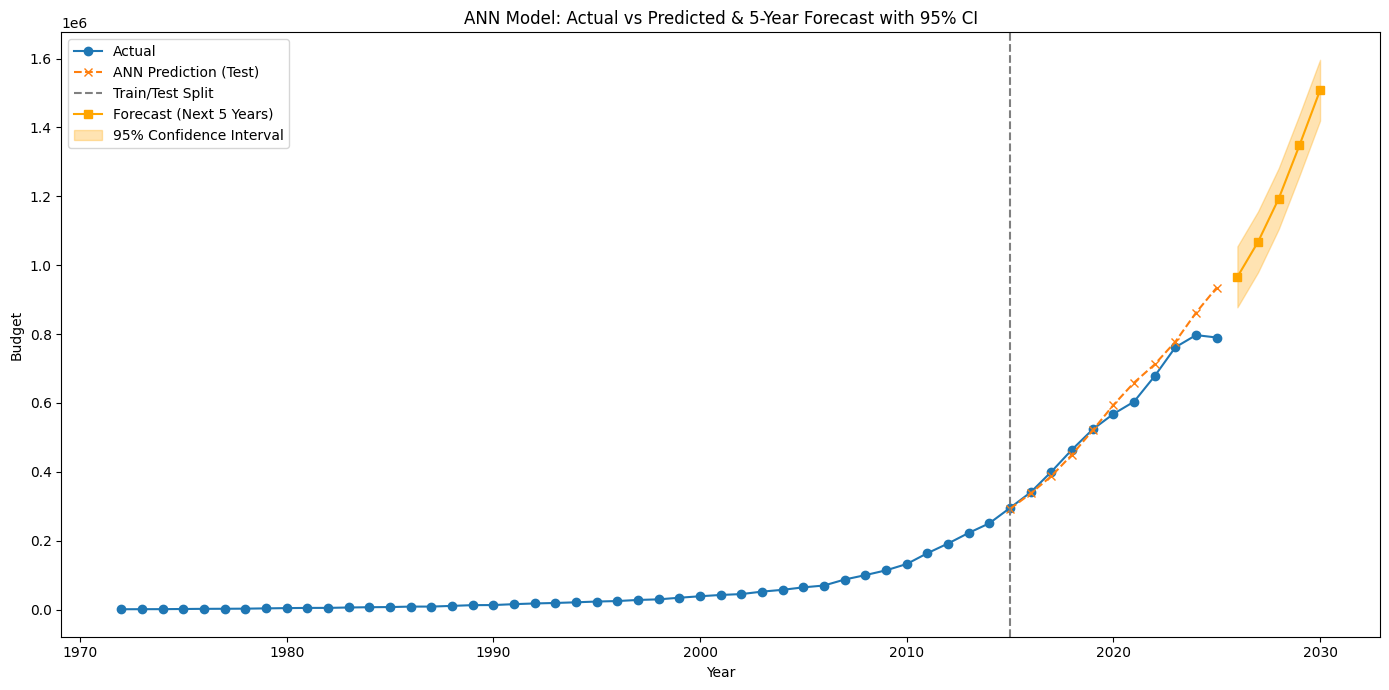

In [2]:
import matplotlib.pyplot as plt

# 1. Calculate residuals on test set
residuals = y_true - y_pred
resid_std = np.std(residuals)

# 2. Forecast next 5 years (already done)
future_steps = 5
last_seq = budget_scaled[-time_steps:].flatten()
forecast_scaled = []

for _ in range(future_steps):
    pred_scaled = model.predict(np.array([last_seq]))[0, 0]
    forecast_scaled.append(pred_scaled)
    last_seq = np.roll(last_seq, -1)
    last_seq[-1] = pred_scaled

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
future_years = np.arange(years[-1] + 1, years[-1] + 1 + future_steps)

# 3. Compute 95% confidence intervals for the forecast
ci_upper = forecast + 1.96 * resid_std
ci_lower = forecast - 1.96 * resid_std

# 4. Print forecast values with CI
print("Forecast for next 5 years with 95% CI:")
for year, fcst, lower, upper in zip(future_years, forecast, ci_lower, ci_upper):
    print(f"Year {year}: {fcst:.2f} (95% CI: {lower:.2f} - {upper:.2f})")

# 5. Plot
plt.figure(figsize=(14, 7))
plt.plot(years, budget, label='Actual', marker='o')
plt.plot(years[train_size:], y_pred, label='ANN Prediction (Test)', linestyle='--', marker='x')
plt.axvline(x=years[train_size], color='gray', linestyle='--', label='Train/Test Split')

plt.plot(future_years, forecast, label='Forecast (Next 5 Years)', color='orange', marker='s')
plt.fill_between(future_years, ci_lower, ci_upper, color='orange', alpha=0.3, label='95% Confidence Interval')

plt.xlabel("Year")
plt.ylabel("Budget")
plt.title("ANN Model: Actual vs Predicted & 5-Year Forecast with 95% CI")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

📊 Final Evaluation: Hybrid ARIMA(2,2,3) + ANN
✅ RMSE         : 88882.8146
✅ MAE          : 85314.6618
✅ MAPE (%)     : 13.26
✅ Accuracy (%) : 86.74
✅ R² Score     : 0.4446


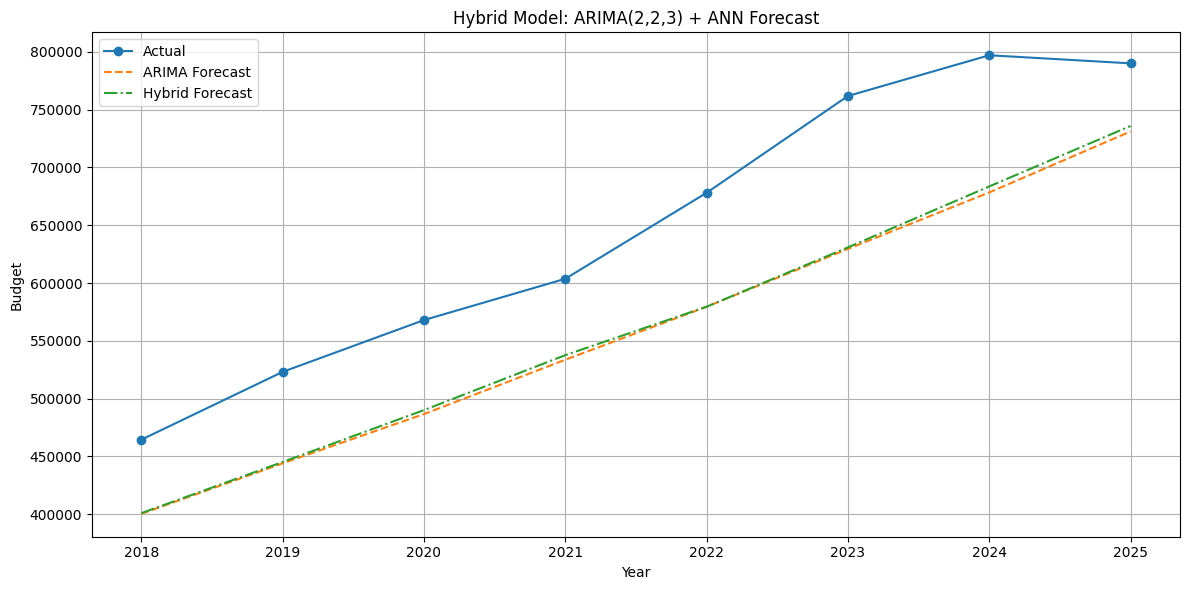

In [ ]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Setup
warnings.filterwarnings("ignore")
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load data

budget = df['Budget'].values.astype(float)
years = df['Year'].values

# Split
total_size = len(budget)
train_size = int(total_size * 0.8)
budget_train, budget_test = budget[:train_size], budget[train_size:]
years_test = years[train_size:]

# Metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy_from_mape(mape_val):
    return 100 - mape_val

# Best ARIMA(2,2,3)
order = (2, 2, 3)
best_arima_model = ARIMA(budget_train, order=order).fit()
arima_pred_test = best_arima_model.predict(start=train_size, end=total_size-1)
arima_resid_train = best_arima_model.resid

# ANN config: time_steps=3, units=64, dropout=0.2, batch_size=16
scaler = MinMaxScaler()
budget_scaled = scaler.fit_transform(budget.reshape(-1, 1))

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Hybrid ARIMA + ANN on residuals
scaler_resid = MinMaxScaler()
resid_scaled = scaler_resid.fit_transform(arima_resid_train.reshape(-1, 1))
time_steps = 3
Xr, yr = create_sequences(resid_scaled, time_steps)
Xr_train = Xr[:int(len(Xr)*0.8)]
Xr_test = Xr[int(len(Xr)*0.8):]
yr_train = yr[:int(len(yr)*0.8)]
yr_test = yr[int(len(yr)*0.8):]

model_hybrid = Sequential([
    Dense(64, activation='relu', input_shape=(time_steps,)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
model_hybrid.compile(optimizer='adam', loss='mse')
model_hybrid.fit(Xr_train, yr_train, epochs=100, batch_size=16,
                 validation_split=0.1, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)

yr_pred_scaled = model_hybrid.predict(Xr_test)
yr_pred = scaler_resid.inverse_transform(yr_pred_scaled).flatten()
arima_last = best_arima_model.predict(start=train_size, end=total_size-1)
arima_part = arima_last[-len(yr_pred):]
hybrid_pred = arima_part + yr_pred
hybrid_true = budget[-len(hybrid_pred):]

# Hybrid Metrics
hybrid_rmse = np.sqrt(mean_squared_error(hybrid_true, hybrid_pred))
hybrid_mae = mean_absolute_error(hybrid_true, hybrid_pred)
hybrid_mape_val = mape(hybrid_true, hybrid_pred)
hybrid_r2 = r2_score(hybrid_true, hybrid_pred)
hybrid_acc = accuracy_from_mape(hybrid_mape_val)

# Print Results
print("\n\U0001F4CA Final Evaluation: Hybrid ARIMA(2,2,3) + ANN")
print(f"\u2705 RMSE         : {hybrid_rmse:.4f}")
print(f"\u2705 MAE          : {hybrid_mae:.4f}")
print(f"\u2705 MAPE (%)     : {hybrid_mape_val:.2f}")
print(f"\u2705 Accuracy (%) : {hybrid_acc:.2f}")
print(f"\u2705 R² Score     : {hybrid_r2:.4f}")

# Optional Plot
plt.figure(figsize=(12, 6))
plt.plot(years_test[-len(hybrid_pred):], hybrid_true, label='Actual', marker='o')
plt.plot(years_test[-len(hybrid_pred):], arima_part, label='ARIMA Forecast', linestyle='--')
plt.plot(years_test[-len(hybrid_pred):], hybrid_pred, label='Hybrid Forecast', linestyle='-.')
plt.xlabel("Year")
plt.ylabel("Budget")
plt.title("Hybrid Model: ARIMA(2,2,3) + ANN Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Formatter to show full values
def format_with_commas(x, pos):
    return f'{int(x):,}'


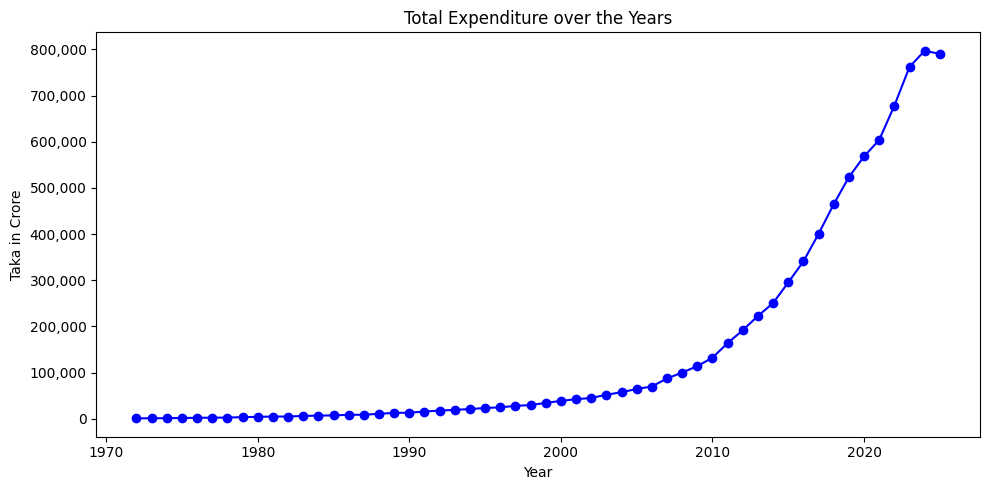

In [ ]:
# Plot 1: Budget
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df['Budget'], label='Total Expenditure', color='blue', marker='o')
plt.xlabel('Year')
plt.ylabel('Taka in Crore')
plt.title('Total Expenditure over the Years')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_with_commas))
plt.grid(False)
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# Set random seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Load data
file_path = r"C:\\Users\\P.Carbon\\Downloads\\Project-Budget\\Data3.csv"
df = pd.read_csv(file_path)
budget = df['Budget'].values.astype(float)

# Train/test split
train_size = int(len(budget) * 0.8)
budget_train, budget_test = budget[:train_size], budget[train_size:]

# Scale budget
total_scaler = MinMaxScaler()
budget_scaled = total_scaler.fit_transform(budget.reshape(-1, 1))

# Prepare sequences
def create_ann_seq(data, time_steps=3):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i].flatten())
        y.append(data[i])
    return np.array(X), np.array(y)

def create_lstm_seq(data, time_steps=3):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Time steps
time_steps = 3
X_ann, y_ann = create_ann_seq(budget_scaled, time_steps)
X_lstm, y_lstm = create_lstm_seq(budget_scaled, time_steps)

# Align ANN and LSTM input
y = y_ann  # same
X_ann = X_ann
X_lstm = X_lstm

# Train/test split
X_ann_train, X_ann_test = X_ann[:train_size - time_steps], X_ann[train_size - time_steps:]
X_lstm_train, X_lstm_test = X_lstm[:train_size - time_steps], X_lstm[train_size - time_steps:]
y_train, y_test = y[:train_size - time_steps], y[train_size - time_steps:]

# Hybrid ANN + LSTM Model
input_ann = Input(shape=(time_steps,), name="ANN_Input")
ann_branch = Dense(64, activation='relu')(input_ann)
ann_branch = Dropout(0.2)(ann_branch)

input_lstm = Input(shape=(time_steps, 1), name="LSTM_Input")
lstm_branch = LSTM(8, activation='tanh', return_sequences=False)(input_lstm)
lstm_branch = Dropout(0.2)(lstm_branch)

combined = Concatenate()([ann_branch, lstm_branch])
output = Dense(1)(combined)

model = Model(inputs=[input_ann, input_lstm], outputs=output)
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    [X_ann_train, X_lstm_train], y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred_scaled = model.predict([X_ann_test, X_lstm_test]).flatten()
y_pred = total_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = total_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print("\n✅ Hybrid ANN + LSTM Results")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R²: {r2:.4f}")


Epoch 1/50
5/5 [==============================] - 26s 1s/step - loss: 0.0012 - val_loss: 0.0320
Epoch 2/50
5/5 [==============================] - 0s 97ms/step - loss: 8.6978e-04 - val_loss: 0.0232
Epoch 3/50
5/5 [==============================] - 0s 58ms/step - loss: 8.4764e-04 - val_loss: 0.0194
Epoch 4/50
5/5 [==============================] - 0s 55ms/step - loss: 4.9484e-04 - val_loss: 0.0178
Epoch 5/50
5/5 [==============================] - 0s 53ms/step - loss: 7.0085e-04 - val_loss: 0.0169
Epoch 6/50
5/5 [==============================] - 0s 57ms/step - loss: 4.4840e-04 - val_loss: 0.0156
Epoch 7/50
5/5 [==============================] - 0s 61ms/step - loss: 4.7863e-04 - val_loss: 0.0131
Epoch 8/50
5/5 [==============================] - 0s 64ms/step - loss: 4.3103e-04 - val_loss: 0.0099
Epoch 9/50
5/5 [==============================] - 0s 67ms/step - loss: 2.3092e-04 - val_loss: 0.0082
Epoch 10/50
5/5 [==============================] - 0s 83ms/step - loss: 1.3500e-04 - val_loss: 0

In [ ]:
import pandas as pd
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Setup
warnings.filterwarnings("ignore")
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ==== Load dataset ====
file_path = r"C:\Users\P.Carbon\Downloads\Project-Budget\Data3.csv"
df = pd.read_csv(file_path)
Budget = df['Budget'].values.astype(float)  # Changed from GDP to Budget
years = df['Year'].values

# ==== Train/Test split ====
total_size = len(Budget)
train_size = int(total_size * 0.8)
Budget_train, Budget_test = Budget[:train_size], Budget[train_size:]
years_test = years[train_size:]

# ==== Helper functions ====
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy_from_mape(mape_val):
    return 100 - mape_val

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# ==== Parameter grids ====
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

time_steps_list = [2, 3]
units_list = [16, 32, 64]
dropout_rates = [0.1, 0.2]
batch_sizes = [8, 16]

results = []

# ==== Hybrid ARIMA + ANN loop ====
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit ARIMA on training set
                arima_model = ARIMA(Budget_train, order=(p, d, q)).fit()

                # Predict on full dataset to get residuals
                arima_pred_train = arima_model.predict(start=0, end=train_size - 1)
                residuals_train = Budget_train - arima_pred_train

                # Prepare test predictions from ARIMA
                arima_pred_test = arima_model.predict(start=train_size, end=total_size - 1)
                residuals_test = Budget_test - arima_pred_test

                for time_steps in time_steps_list:
                    # Scale residuals for ANN
                    scaler_resid = MinMaxScaler()
                    resid_scaled = scaler_resid.fit_transform(residuals_train.reshape(-1, 1))

                    # Create sequences from scaled residuals
                    Xr, yr = create_sequences(resid_scaled, time_steps)

                    # Align ANN training with ARIMA forecast period
                    Xr_train = Xr
                    yr_train = yr

                    for units in units_list:
                        for dropout_rate in dropout_rates:
                            for batch_size in batch_sizes:
                                # Build ANN model
                                model_hybrid = Sequential([
                                    Dense(units, activation='relu', input_shape=(time_steps,)),
                                    Dropout(dropout_rate),
                                    Dense(units, activation='relu'),
                                    Dropout(dropout_rate),
                                    Dense(1)
                                ])
                                model_hybrid.compile(optimizer='adam', loss='mse')
                                early_stop = EarlyStopping(patience=10, restore_best_weights=True)

                                # Fit ANN on residuals
                                model_hybrid.fit(
                                    Xr_train, yr_train,
                                    epochs=50,
                                    batch_size=batch_size,
                                    validation_split=0.1,
                                    callbacks=[early_stop],
                                    verbose=0
                                )

                                # Prepare residuals test set for ANN
                                resid_test_scaled = scaler_resid.transform(residuals_test.reshape(-1, 1))
                                Xr_test, _ = create_sequences(resid_test_scaled, time_steps)

                                # ANN residual predictions
                                ann_resid_pred_scaled = model_hybrid.predict(Xr_test, verbose=0)
                                ann_resid_pred = scaler_resid.inverse_transform(ann_resid_pred_scaled).flatten()

                                # Align lengths
                                arima_pred_test_adj = arima_pred_test[-len(ann_resid_pred):]
                                Budget_test_adj = Budget_test[-len(ann_resid_pred):]

                                # Hybrid prediction = ARIMA + ANN residual correction
                                hybrid_pred = arima_pred_test_adj + ann_resid_pred

                                # Metrics
                                hybrid_rmse = np.sqrt(mean_squared_error(Budget_test_adj, hybrid_pred))
                                hybrid_mae = mean_absolute_error(Budget_test_adj, hybrid_pred)
                                hybrid_mape_val = mape(Budget_test_adj, hybrid_pred)
                                hybrid_r2 = r2_score(Budget_test_adj, hybrid_pred)
                                hybrid_acc = accuracy_from_mape(hybrid_mape_val)

                                results.append({
                                    'ARIMA_order': (p, d, q),
                                    'time_steps': time_steps,
                                    'units': units,
                                    'dropout': dropout_rate,
                                    'batch_size': batch_size,
                                    'RMSE': hybrid_rmse,
                                    'MAE': hybrid_mae,
                                    'MAPE': hybrid_mape_val,
                                    'Accuracy (%)': hybrid_acc,
                                    'R2': hybrid_r2
                                })
            except Exception as e:
                continue

# ==== Convert to DataFrame and Show Top Models ====
results_df = pd.DataFrame(results)
top_5 = results_df.sort_values('MAPE').head(5)  # sort by MAPE for stability
print("\nTop 5 Hybrid Models (by MAPE):")
print(top_5.round(4))
